In [10]:
# Import necessary libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import joblib


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [11]:
# Function to load images and labels from a folder
def load_images_from_folder(folder_path, label, image_size=(32, 32)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path).convert('L')  # Convert image to grayscale
            img = img.resize(image_size)  # Resize to the desired size
            img_array = np.array(img).flatten()  # Flatten the image to a 1D vector
            images.append(img_array)
            labels.append(label)
    return images, labels


In [12]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize weights and bias
        self.w = np.zeros(n_features)
        self.b = 0
        
        # Fixed: Removed redundant label conversion (already -1/1)
        y_ = y  # Directly use labels since we already have -1/1
        
        # Gradient Descent
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                
                if condition:
                    dw = 2 * self.lambda_param * self.w
                    db = 0
                else:
                    dw = 2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    db = y_[idx]
                
                # Update weights and bias
                self.w -= self.lr * dw
                self.b -= self.lr * db

    def predict(self, X):
        linear_output = np.dot(X, self.w) - self.b
        # Fixed: Ensure predictions are only -1 or 1
        return np.where(linear_output >= 0, 1, -1)


In [13]:
# Set paths for benign and malignant images (update these paths accordingly)
benign_path = "/mnt/myFiles/Dataset of Mammography with Benign Malignant Breast Masses/DDSM Dataset/Benign Masses"
malignant_path = "/mnt/myFiles/Dataset of Mammography with Benign Malignant Breast Masses/DDSM Dataset/Malignant Masses"

# Image size for resizing images
image_size = (32, 32)

# Load images and labels from the specified directories
benign_images, benign_labels = load_images_from_folder(benign_path, label=-1, image_size=image_size)
malignant_images, malignant_labels = load_images_from_folder(malignant_path, label=1, image_size=image_size)

# Combine the data into feature matrix X and label vector y
X = np.array(benign_images + malignant_images)  # All the images in a single array
y = np.array(benign_labels + malignant_labels)  # Corresponding labels

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Create an instance of the SVM class and fit the model on training data
svm_model = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=1000)
svm_model.fit(X_train, y_train)




Training Accuracy: 95.12%
Test Accuracy: 94.82%

Classification Report for Test Set:
Benign:
  Precision: 0.99
  Recall: 0.90
  F1-score: 0.94
  Support: 1191.00
Malignant:
  Precision: 0.92
  Recall: 0.99
  F1-score: 0.95
  Support: 1435.00

Confusion Matrix:
[[1068  123]
 [  13 1422]]


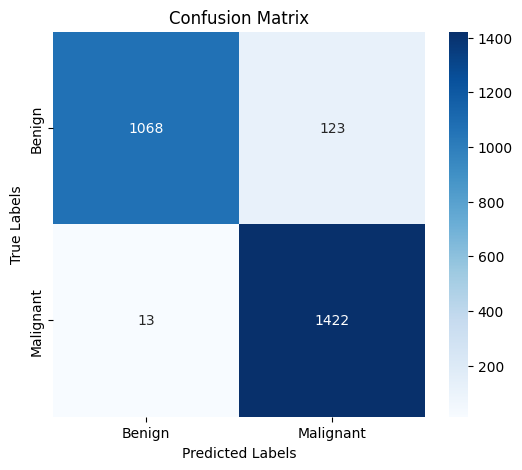

In [15]:
# Make predictions on both training and test sets
train_predictions = svm_model.predict(X_train)
test_predictions = svm_model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Enhanced classification report
report = classification_report(y_test, test_predictions, target_names=['Benign', 'Malignant'], output_dict=True)

# Extract only precision, recall, f1-score, and support
filtered_report = {
    label: {metric: values[metric] for metric in ["precision", "recall", "f1-score", "support"]}
    for label, values in report.items() if label in ['Benign', 'Malignant']
}

print("\nClassification Report for Test Set:")
for label, metrics in filtered_report.items():
    print(f"{label}:")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
print("\nConfusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


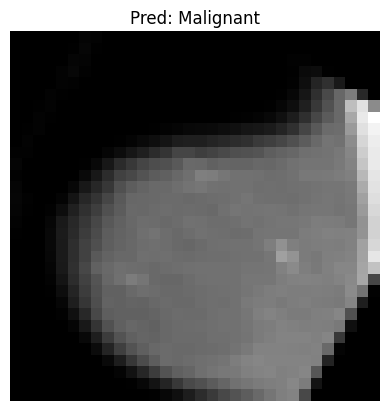

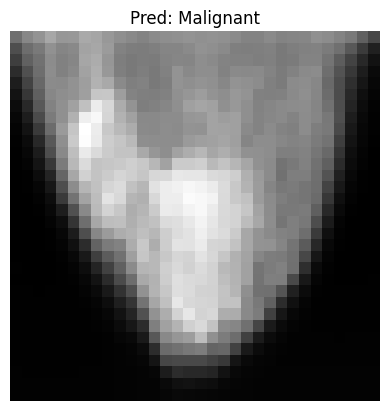

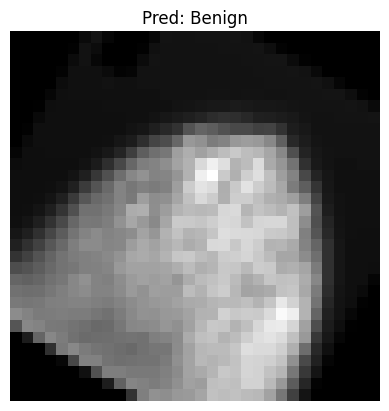

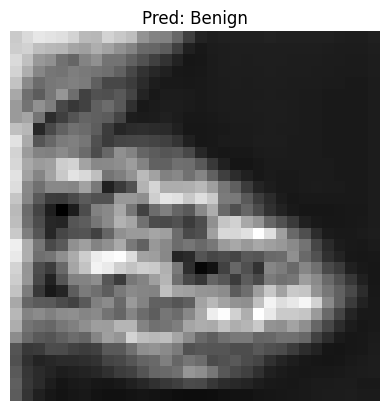

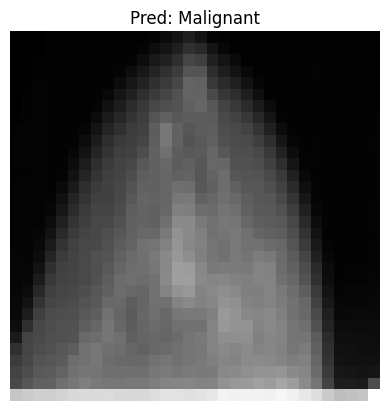

In [16]:
# Visualize some of the test images along with their predicted labels 
for i in range(5):  # Display first 5 test images with predictions
    plt.imshow(X_test[i].reshape(image_size), cmap='gray')  # Reshape to original image size for display
    plt.title(f"Pred: {'Malignant' if test_predictions[i] == 1 else 'Benign'}")
    plt.axis('off')  # Hide axes for better visualization
    plt.show()


In [17]:
# Save the trained model using joblib 
joblib.dump(svm_model, 'svm_model.pkl')
print("Model saved as 'svm_model.pkl'")


Model saved as 'svm_model.pkl'


In [18]:
model_info = {
    "Model Type": "Linear SVM",
    "Training Accuracy": f"{train_accuracy * 100:.2f}%",
    "Test Accuracy": f"{test_accuracy * 100:.2f}%",
    "Learning Rate": svm_model.lr,
    "Lambda Parameter": svm_model.lambda_param,
    "Number of Iterations": svm_model.n_iters,
    "Image Size": image_size,
    "Number of Features": X_train.shape[1],
    "Number of Training Samples": X_train.shape[0],
    "Number of Testing Samples": X_test.shape[0],
    "Confusion Matrix": cm.tolist(),  # Convert to list for serialization
    "Classification Report": filtered_report
}

print("\nModel Information:")
for key, value in model_info.items():
    print(f"{key}: {value}")


Model Information:
Model Type: Linear SVM
Training Accuracy: 95.12%
Test Accuracy: 94.82%
Learning Rate: 0.001
Lambda Parameter: 0.01
Number of Iterations: 1000
Image Size: (32, 32)
Number of Features: 1024
Number of Training Samples: 10502
Number of Testing Samples: 2626
Confusion Matrix: [[1068, 123], [13, 1422]]
Classification Report: {'Benign': {'precision': 0.9879740980573543, 'recall': 0.8967254408060453, 'f1-score': 0.9401408450704225, 'support': 1191.0}, 'Malignant': {'precision': 0.920388349514563, 'recall': 0.9909407665505227, 'f1-score': 0.9543624161073826, 'support': 1435.0}}
